### Basic Concepts: Nodes, Edges & State

In [20]:
from typing import TypedDict
from langgraph.graph import END, START, StateGraph


class InputState(TypedDict):
    string_value: str
    numeric_value: int


def modify_state(input: InputState):
    print(f"Current value: {input}")
    return input
# The return value of a node defines the state inside the next node. In LG, u always change the state then return new state


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge(START, "branch_a") #This is done optional as langgraph internally does it
graph.add_edge("branch_a", "branch_b") # We will first execute branch A then execute branch B
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a") # Langgraph needs to know where to start from

runnable = graph.compile()

### Visualize graph

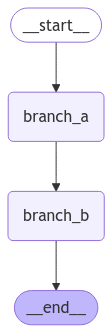

In [21]:
from IPython.display import Image, display # To Display in jupyter notebook
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [23]:
runnable.invoke({"string_value": "a"})

Current value: {'string_value': 'a'}
Current value: {'string_value': 'a'}


{'string_value': 'a'}

In [24]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

Current value: {'string_value': 'a', 'numeric_value': 1}
Current value: {'string_value': 'a', 'numeric_value': 1}


{'string_value': 'a', 'numeric_value': 1}

In [25]:
def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 1
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)


graph.set_entry_point("branch_a")

runnable = graph.compile()

In [26]:
try:
    runnable.invoke({"string_value": "a"})
except KeyError as e:
    print(e)

'numeric_value'


In [27]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'aaa', 'numeric_value': 3}

### Why not use just LCEL?

In [8]:
from langchain_core.runnables import RunnableLambda

In [9]:
runnable = RunnableLambda(modify_state)

chain = runnable | runnable

In [ ]:
chain.invoke({"string_value": "a", "numeric_value": 1})

### Cycles and Conditional Edges

In [29]:
def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 1
    return input


def router(input: InputState):
    if input["numeric_value"] < 5:
        return "branch_a"
    else:
        return "__end__"


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
#Conditional takes 3 arguments: name of node that we want to route from so branch_b, the router function, output of the router(maybe) 
graph.add_conditional_edges(
    "branch_b", router, {"branch_a": "branch_a", "__end__": END}
)

graph.set_entry_point("branch_a")

runnable = graph.compile()

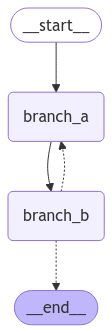

In [30]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [33]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'aaaaa', 'numeric_value': 5}

### Reducer functions

In [34]:
from typing import TypedDict, Annotated
from langgraph.graph import END, StateGraph
from operator import add # The reducer function


# Reducers are essential for determing how updates from nodes are applied to a state. 
# Each key in a state such as no_change_value, string_value, numeric_value, list_value has its own independent reducer function.
#If no reducer function is specified, then the updates to the key will default to overwriting the existing value

class InputState(TypedDict):
    no_change_value: str
    string_value: Annotated[str, add]
    numeric_value: Annotated[int, add]
    list_value: Annotated[list[str], add]


def modify_state(input: InputState):
    return input

In [35]:
graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [37]:
runnable.invoke(
    {
        "no_change_value": "a",
        "string_value": "a",
        "numeric_value": 1,
        "list_value": ["a"],
    }
)

{'no_change_value': 'a',
 'string_value': 'aaaa',
 'numeric_value': 4,
 'list_value': ['a', 'a', 'a', 'a']}

### Alternative State

In [42]:
from typing import TypedDict
from langgraph.graph import END, StateGraph
from pydantic import BaseModel


# class InputState(TypedDict):
#     string_value: str
#     numeric_value: int


class InputState(BaseModel):
      string_value: str
      numeric_value: int


def modify_state(input: InputState):
    string_value = input["string_value"] #This is aka the get method which Pydantic doesnt work with since it works with attributes
    # string_value = input.string_value #This is an attribute and you can test in the next cell below
    print(string_value)
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [43]:
runnable.invoke({"string_value": "a", "numeric_value": "a"})

ValidationError: 1 validation error for InputState
numeric_value
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='a', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/int_parsing